In [1]:
import os, pandas as pd, numpy as np
from fredapi import Fred
fred = Fred(api_key='cba33361256956afaa259454a226507f')
#fred = Fred(api_key=os.getenv('FRED_API_KEY'))

In [2]:
verified_series = {
    'CPI': 'CPIAUCSL',
    'Real_DPI': 'DSPIC96',
    'RetailFoodSales': 'RSAFS',
    'Unemployment': 'UNRATE',
    'Sentiment': 'UMCSENT',
    'Recession': 'USREC'
}

# Test the series to make usre I got the names right
for name, sid in verified_series.items():
    try:
        data = fred.get_series(sid)
        print(f"✓ {name} ({sid}): SUCCESS")
    except Exception as e:
        print(f"✗ {name} ({sid}): FAILED - {e}")

✓ CPI (CPIAUCSL): SUCCESS
✓ Real_DPI (DSPIC96): SUCCESS
✓ RetailFoodSales (RSAFS): SUCCESS
✓ Unemployment (UNRATE): SUCCESS
✓ Sentiment (UMCSENT): SUCCESS
✓ Recession (USREC): SUCCESS


In [3]:
verified_series = {
    'CPI': 'CPIAUCSL',
    'Real_DPI': 'DSPIC96',
    'Retail_Sales': 'RSAFS',
    'Unemployment': 'UNRATE',
    'Sentiment': 'UMCSENT',
    'Recession': 'USREC'
}
df = pd.DataFrame({name: fred.get_series(sid) for name, sid in verified_series.items()})
df.index = pd.to_datetime(df.index)
df = df.resample('ME').last()
df = df[df.index >= '1992-01-01']


In [4]:
# Calculate the percentage changes to see get a summary table to start making sense on the data
try:
    # Calculate percentage changes and transformations
    df['log_Retail'] = np.log(df['Retail_Sales'])
    df['Retail_pct'] = df['log_Retail'].diff() * 100
    df['RealDPI_pct'] = np.log(df['Real_DPI']).diff() * 100
    
    # Fixed CPI percentage change
    df['CPI_pct'] = df['CPI'].pct_change(fill_method=None) * 100
    
    df['Unemp_diff'] = df['Unemployment'].diff()
    df['Sentiment_diff'] = df['Sentiment'].diff()
    df['Recession'] = df['Recession'].fillna(0).astype(int)
    
    print("✅ All transformations completed successfully!")
    print(f"DataFrame shape: {df.shape}")
    print("\nLast 5 rows:")
    display(df.tail())
    
    # Optional: Summary stats
    print("\n📊 Summary of new percentage change columns:")
    pct_cols = ['Retail_pct', 'RealDPI_pct', 'CPI_pct']
    print(df[pct_cols].describe())
    
except Exception as e:
    print(f"❌ Error in processing: {e}")

✅ All transformations completed successfully!
DataFrame shape: (407, 12)

Last 5 rows:


,CPI,Real_DPI,Retail_Sales,Unemployment,Sentiment,Recession,log_Retail,Retail_pct,RealDPI_pct,CPI_pct,Unemp_diff,Sentiment_diff
2025-07-31,322.132,18084.5,727727.0,4.2,61.7,0,13.497681,0.647111,0.267437,0.196579,0.1,1.0
2025-08-31,323.364,18105.1,732059.0,4.3,58.2,0,13.503616,0.593513,0.113845,0.382452,0.1,-3.5
2025-09-30,324.368,18116.1,733258.0,4.4,55.1,0,13.505253,0.163651,0.060738,0.310486,0.1,-3.1
2025-10-31,NaN,NaN,NaN,NaN,53.6,0,NaN,NaN,NaN,NaN,NaN,-1.5
2025-11-30,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN



📊 Summary of new percentage change columns:
       Retail_pct  RealDPI_pct     CPI_pct
count  404.000000   404.000000  404.000000
mean     0.378089     0.219125    0.211592
std      1.726355     1.812059    0.270853
min    -15.512911   -16.374087   -1.770548
25%     -0.117800     0.024847    0.080163
50%      0.418492     0.227601    0.213296
75%      0.909873     0.431771    0.328211
max     17.651837    20.615299    1.376849


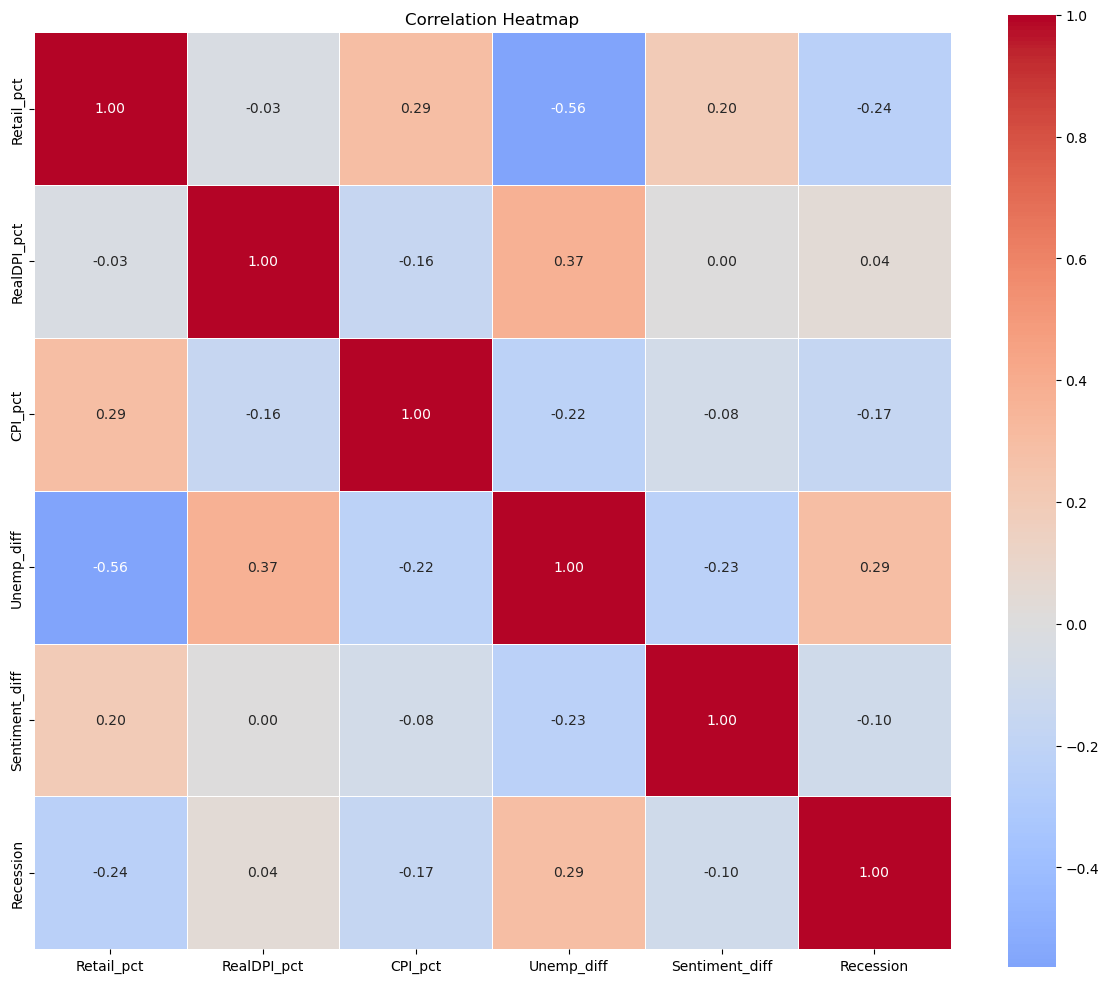

In [5]:
# We want to see if correlations stick out and if anything suprises us
import matplotlib.pyplot as plt
import seaborn as sns
feature_cols = ['Retail_pct', 'RealDPI_pct', 'CPI_pct', 'Unemp_diff', 'Sentiment_diff', 'Recession']
corr_matrix = df[feature_cols].corr()

plt.figure(figsize = (12,10))
sns.heatmap(corr_matrix,annot = True, cmap = 'coolwarm', center = 0, square = True, fmt = '.2f', linewidth=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

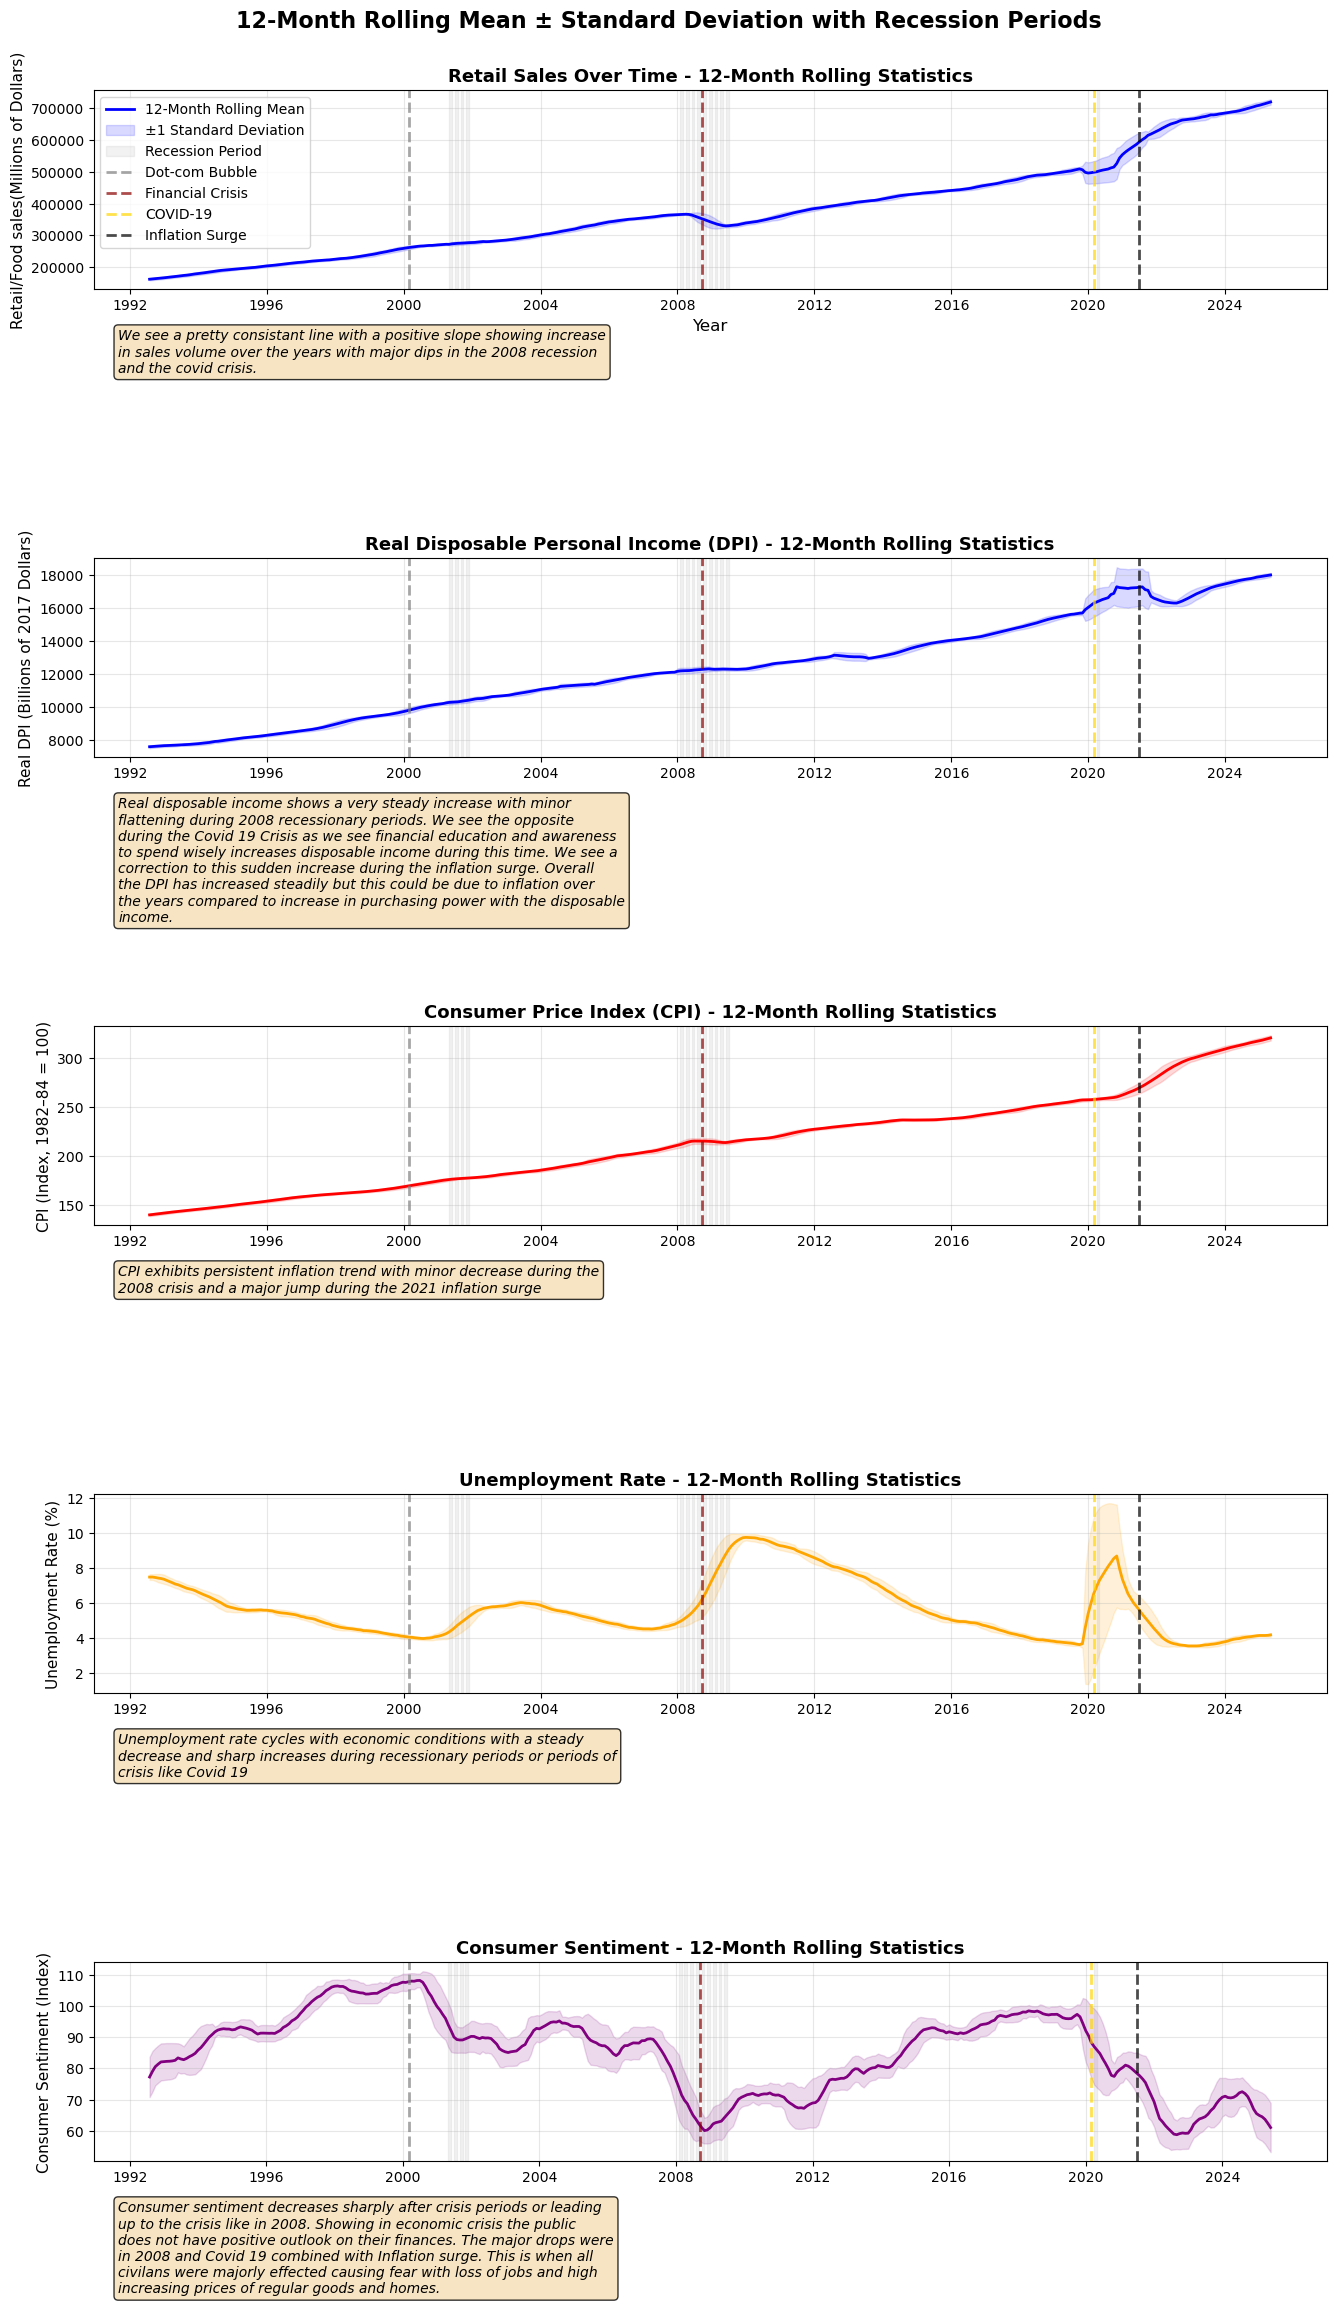

In [6]:
import textwrap
window = 12 # Months
# Create subplots - much clearer when variables have different scales
fig, axes = plt.subplots(5, 1, figsize=(14, 24))
axes = axes.flatten()

#These are all the variables, titles of the graphs, labels with correct units and macro events that I hand picked that could be relevant for our time
# period while also adding some captions

variables = ['Retail_Sales', 'Real_DPI', 'CPI', 'Unemployment', 'Sentiment']
colors = ['blue', 'blue', 'red', 'orange', 'purple']

titles = [
    'Retail Sales Over Time', 
    'Real Disposable Personal Income (DPI)', 
    'Consumer Price Index (CPI)', 
    'Unemployment Rate', 
    'Consumer Sentiment'
]

y_labels = [
    "Retail/Food sales(Millions of Dollars)", 
    "Real DPI (Billions of 2017 Dollars)", 
    "CPI (Index, 1982–84 = 100)", 
    "Unemployment Rate (%)", 
    "Consumer Sentiment (Index)"
]

# Custom legend labels for each variable
legend_labels = [
    {'mean': '12-Month Rolling Mean', 'std': '±1 Standard Deviation'},
    {'mean': '12-Month Rolling Mean', 'std': '±1 Standard Deviation'},
    {'mean': '12-Month Rolling Mean', 'std': '±1 Standard Deviation'},
    {'mean': '12-Month Rolling Mean', 'std': '±1 Standard Deviation'},
    {'mean': '12-Month Rolling Mean', 'std': '±1 Standard Deviation'}
]

macroevent_dates = [
    # Format: (date, color, label, linewidth, alpha)
    ("2000-03-01", 'gray', 'Dot-com Bubble', 2, 0.7),
    ("2008-09-15", 'darkred', 'Financial Crisis', 2, 0.7),
    ("2020-03-01", 'gold', 'COVID-19', 2, 0.7),
    ("2021-07-01", 'black', 'Inflation Surge', 2, 0.7)
]
captions = [
    "We see a pretty consistant line with a positive slope showing increase in sales volume over the years with major dips in the 2008 recession and the covid crisis.",
    "Real disposable income shows a very steady increase with minor flattening during 2008 recessionary periods. We see the opposite during the Covid 19 Crisis as we see financial education and awareness to spend wisely increases disposable income during this time. We see a correction to this sudden increase during the inflation surge. Overall the DPI has increased steadily but this could be due to inflation over the years compared to increase in purchasing power with the disposable income.",
    "CPI exhibits persistent inflation trend with minor decrease during the 2008 crisis and a major jump during the 2021 inflation surge",
    "Unemployment rate cycles with economic conditions with a steady decrease and sharp increases during recessionary periods or periods of crisis like Covid 19",
    "Consumer sentiment decreases sharply after crisis periods or leading up to the crisis like in 2008. Showing in economic crisis the public does not have positive outlook on their finances. The major drops were in 2008 and Covid 19 combined with Inflation surge. This is when all civilans were majorly effected causing fear with loss of jobs and high increasing prices of regular goods and homes."
]
for i, var in enumerate(variables):
    # Calculate rolling statistics
    rolling_mean = df[var].rolling(window=window, center=True).mean()
    rolling_std = df[var].rolling(window=window, center=True).std()
    
    # Plot rolling mean line
    axes[i].plot(df.index, rolling_mean, color=colors[i], linewidth=2, label=legend_labels[i]['mean'])
    
    # Plot rolling std shading
    axes[i].fill_between(df.index, 
                        rolling_mean - rolling_std, 
                        rolling_mean + rolling_std, 
                        color=colors[i], alpha=0.15, label=legend_labels[i]['std'])
    
    # Add recession shading to each subplot
    recession_periods = df[df['Recession'] == 1].index
    for start, end in zip(recession_periods[::2], recession_periods[1::2]):
        axes[i].axvspan(start, end, alpha=0.1, color='grey', label='Recession Period' if start == recession_periods[0] and i == 0 else "")
    #adding the macro events
    for event_date, color, label, linewidth, alpha in macroevent_dates:
        axes[i].axvline(pd.Timestamp(event_date), color=color, linewidth=linewidth, 
                       alpha=alpha, linestyle='--', label=label)
    # These are the labels and captions
    axes[i].set_title(f'{titles[i]} - {window}-Month Rolling Statistics', fontweight='bold', fontsize=13)
    axes[i].set_ylabel(y_labels[i], fontsize=11)
    axes[i].grid(True, alpha=0.3)
 
    wrapped_caption = textwrap.fill(captions[i], width=70)
    axes[i].text(0.02, -0.20, wrapped_caption, transform=axes[i].transAxes, fontsize=10, 
                style='italic', verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
# Only add x-label to the bottom subplot
axes[0].legend()
axes[0].set_xlabel('Year', fontsize=12)

plt.suptitle(f'{window}-Month Rolling Mean ± Standard Deviation with Recession Periods', 
             fontsize=16, fontweight='bold')
plt.tight_layout(pad=3.0, h_pad=4.0, w_pad=2.0)
plt.show()

In [7]:
# We are testing stationarity, we see evidence on non stationarity so we need to double check and see how much differencing we need to do to make it 
# Stationary
from statsmodels.tsa.stattools import adfuller
def adf_stationing(series, use_log=False):
    """
    Tests stationarity step-by-step:
    1. Raw series
    2. Log(series) if use_log=True
    3. Diff(log(series)) or Diff(series)
    
    Returns:
        stationary_series, message
    """
    print("ADF TEST")
    
    # Clean NA
    curr_series = series.dropna()
    
    # STEP 1 — Test raw series
    result = adfuller(curr_series)
    print(f"Raw p-value: {result[1]:.5f}")
    
    if result[1] <= 0.05:
        return curr_series
    
    # ==========================
    # STEP 2 — Log transform, Not all data needs log transform, only if we know it grows exponentially
    # ==========================
    if use_log:
        # only log once
        curr_series = np.log(curr_series)
        curr_series = curr_series.dropna()
        result = adfuller(curr_series)
        print(f"Log p-value: {result[1]:.5f}")
        
        if result[1] <= 0.05:
            
            return curr_series
    
    # ==========================
    # STEP 3 — First difference
    # ==========================
    curr_series = curr_series.diff().dropna()
    result = adfuller(curr_series)
    print(f"1st Difference p-value: {result[1]:.5f}")
    
    if result[1] <= 0.05:
       
        return curr_series
    
    # ==========================
    # STEP 4 — Second difference (optional)
    # ==========================
    curr_series = curr_series.diff().dropna()
    result = adfuller(curr_series)
    print(f"2nd Difference p-value: {result[1]:.5f}")
    
    if result[1] <= 0.05:
        
        return curr_series 
    
    # ==========================
    # If still not stationary
    # ==========================
    return None, "ERROR: Still not stationary — consider seasonal differencing or detrending"


In [8]:
#function log as true means we know its exponential growth others are default false, After we compute it stationary we add to our dataframe
df['Station CPI'] = adf_stationing(df['CPI'],use_log = True)
df['Station DPI'] = adf_stationing(df['Real_DPI'],use_log = True)
df['Station Retail'] = adf_stationing(df['Retail_Sales'],use_log = True)
df['Station Unemployment'] = adf_stationing(df['Unemployment'])
df['Station Sentiment'] = adf_stationing(df['Sentiment'])

ADF TEST
Raw p-value: 0.99784
Log p-value: 0.98445
1st Difference p-value: 0.00269
ADF TEST
Raw p-value: 0.97952
Log p-value: 0.72624
1st Difference p-value: 0.00000
ADF TEST
Raw p-value: 0.99783
Log p-value: 0.86391
1st Difference p-value: 0.00000
ADF TEST
Raw p-value: 0.03107
ADF TEST
Raw p-value: 0.54534
1st Difference p-value: 0.00000


In [9]:
import ruptures as rpt
# Bai perron is great to test if and where the break of structures are in our data. We will be looking for a max of 5 breaks and store the dates.
def bai_perron(df, series_name, max_breaks=5, model="l2"):
    """
    series_name: the column to test (must be stationary)
    max_breaks: number of potential breaks to search for
    """

    # Keep the original index!
    series = df[series_name].dropna()
    values = series.values
    index = series.index

    # Fit binary segmentation
    algo = rpt.Binseg(model=model).fit(values)

    # Breakpoint indices (end of segments)
    breakpoints = algo.predict(n_bkps=max_breaks)

    # Convert breakpoint indices → dates
    break_dates = [index[bp - 1] for bp in breakpoints if 0 < bp <= len(index)]
    
    return break_dates


In [10]:
# Finding the bai perron and storing the dates. We are using the stationary data for this.
bp_cpi = bai_perron(df, 'Station CPI', max_breaks=5)
bp_dpi = bai_perron(df, 'Station DPI', max_breaks=5)
bp_retail = bai_perron(df, 'Station Retail', max_breaks=5)
bp_cs = bai_perron(df, 'Station Sentiment', max_breaks=5)
bp_unemp = bai_perron(df,'Station Unemployment', max_breaks=5)

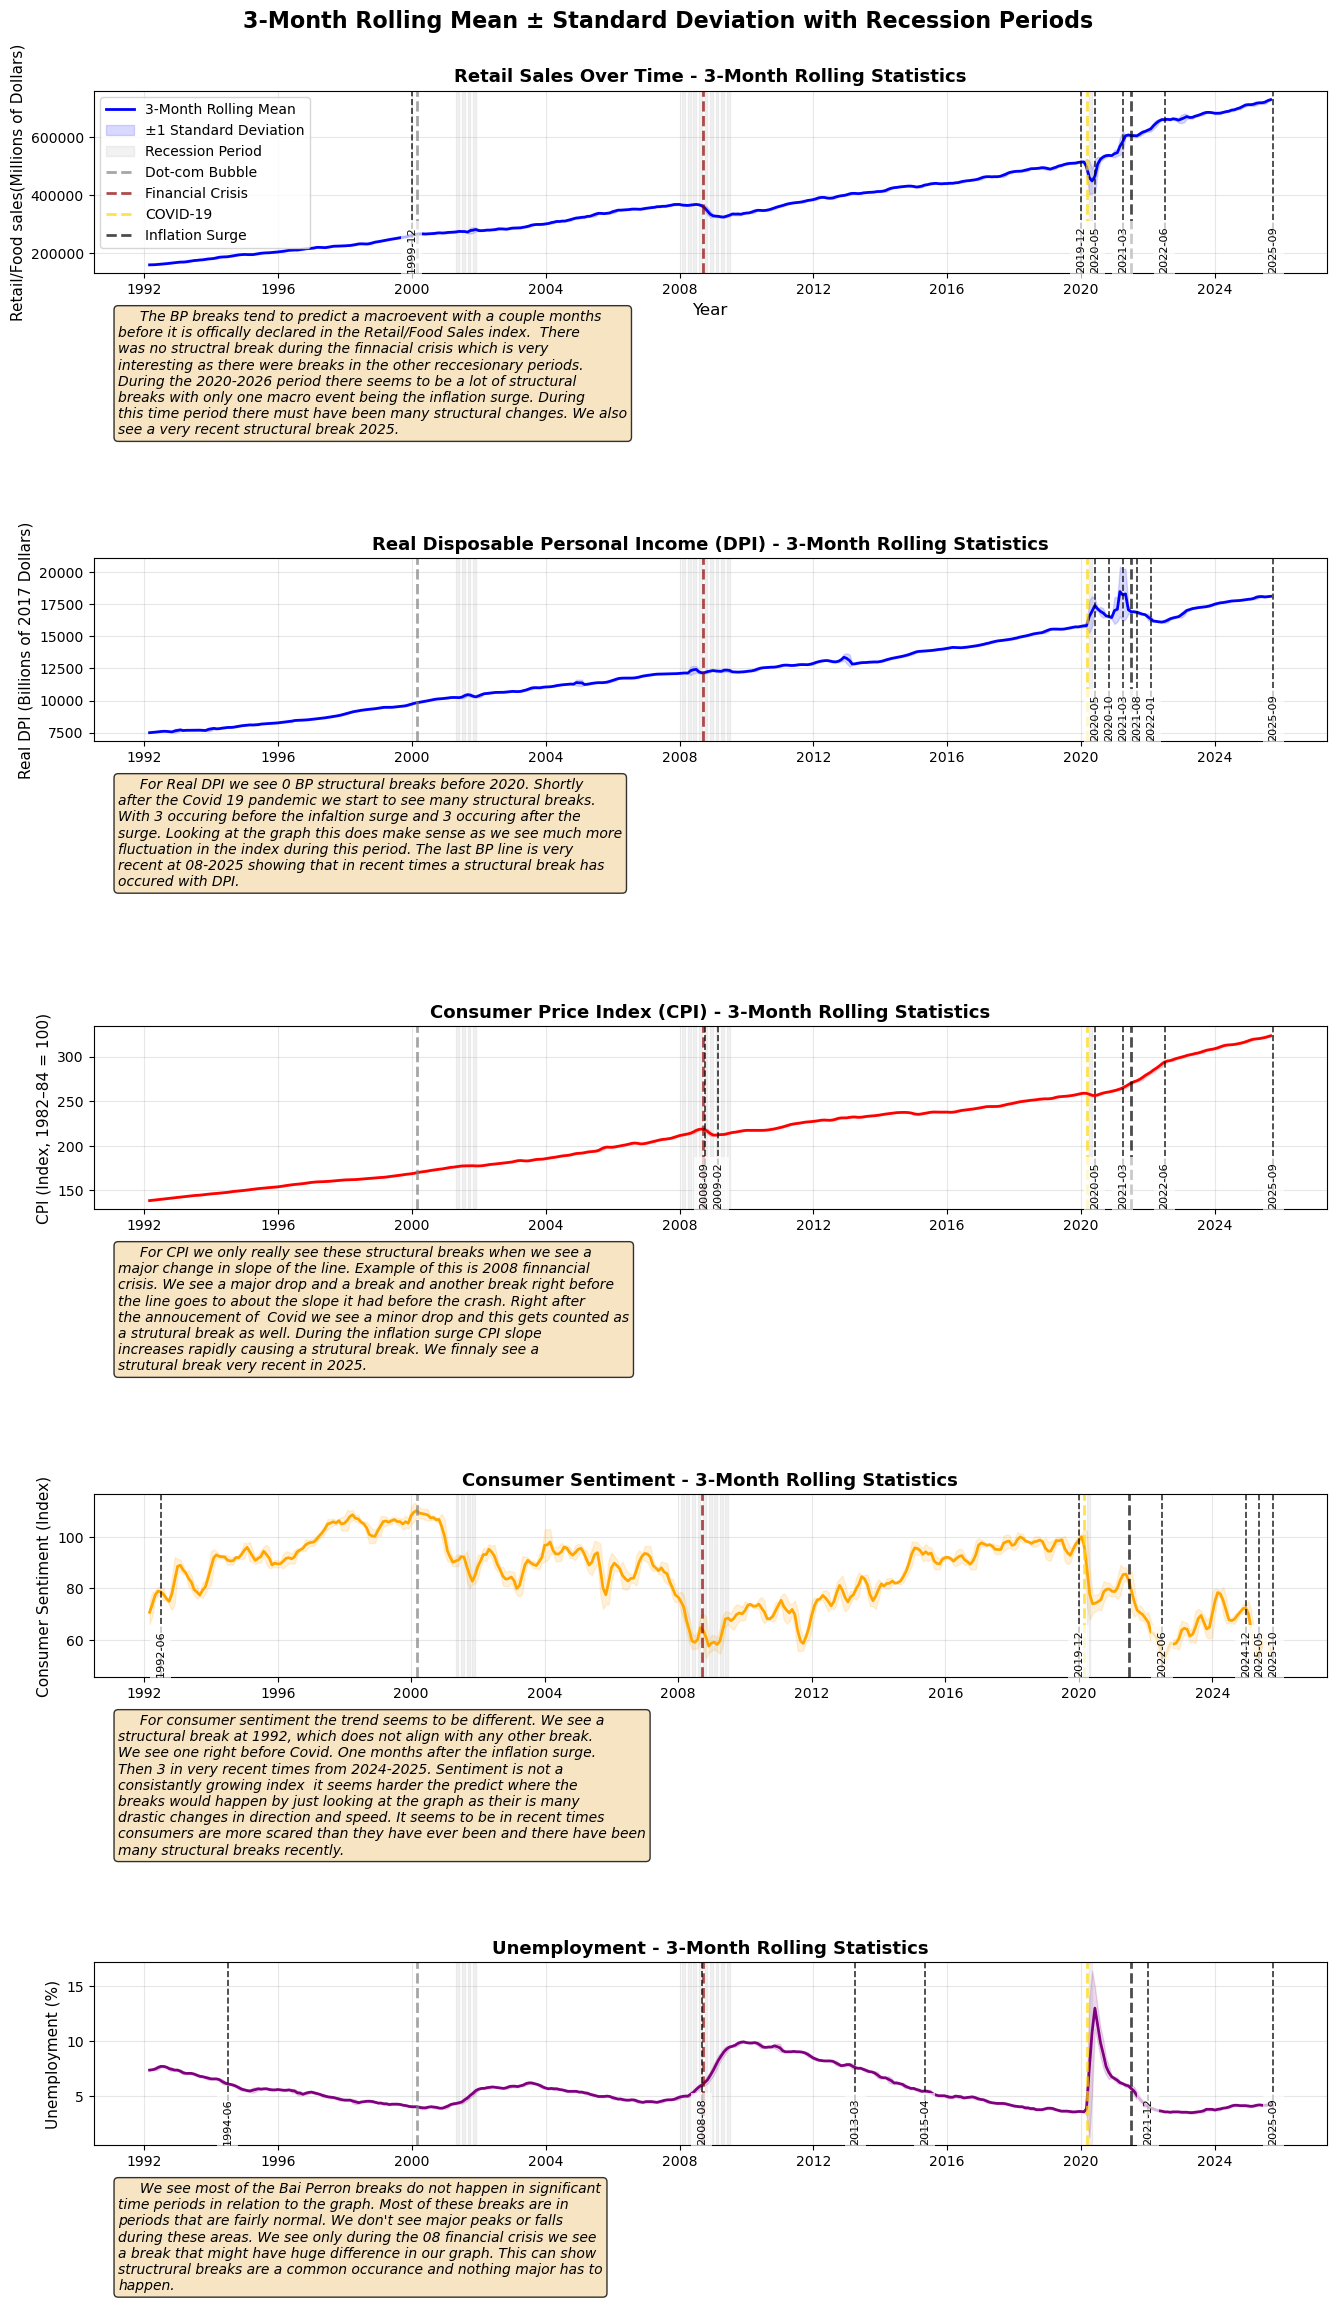

In [11]:
window = 3 # Months
fig, axes = plt.subplots(5, 1, figsize=(14, 24))
axes = axes.flatten()
# Similar structure to above graphs, we are plotting the bai perron we found plotting this on our raw data, we want to see how these days affected the
# indexes and if they align with out macro events.
variables = ['Retail_Sales', 'Real_DPI', 'CPI', 'Sentiment','Unemployment']
colors = ['blue', 'blue', 'red', 'orange', 'purple','yellow']

titles = [
    'Retail Sales Over Time', 
    'Real Disposable Personal Income (DPI)', 
    'Consumer Price Index (CPI)',  
    'Consumer Sentiment',
    'Unemployment'
]

y_labels = [
    "Retail/Food sales(Millions of Dollars)", 
    "Real DPI (Billions of 2017 Dollars)", 
    "CPI (Index, 1982–84 = 100)",  
    "Consumer Sentiment (Index)",
    "Unemployment (%)"
]

# Custom legend labels for each variable
legend_labels = [
    {'mean': '3-Month Rolling Mean', 'std': '±1 Standard Deviation'},
    {'mean': '3-Month Rolling Mean', 'std': '±1 Standard Deviation'},
    {'mean': '3-Month Rolling Mean', 'std': '±1 Standard Deviation'},
    {'mean': '3-Month Rolling Mean', 'std': '±1 Standard Deviation'},
    {'mean': '3-Month Rolling Mean', 'std': '±1 Standard Deviation'}
]

bai_perron_dates = [
    bp_retail,
    bp_dpi,
    bp_cpi,
    bp_cs,
    bp_unemp
]
captions = [
    """
    The BP breaks tend to predict a macroevent with a couple months before it is offically declared in the Retail/Food Sales index.
 There was no structral break during the finnacial crisis which is very interesting as there were breaks in the other reccesionary periods.
 During the 2020-2026 period there seems to be a lot of structural breaks with only one macro event being the inflation surge. During this time period
there must have been many structural changes. We also see a very recent structural break 2025.
    """,
    """
    For Real DPI we see 0 BP structural breaks before 2020. Shortly after the Covid 19 pandemic we start to see many structural breaks. With 3 occuring
before the infaltion surge and 3 occuring after the surge. Looking at the graph this does make sense as we see much more fluctuation in the index during
this period. The last BP line is very recent at 08-2025 showing that in recent times a structural break has occured with DPI.
    """,
    """
    For CPI we only really see these structural breaks when we see a major change in slope of the line. Example of this is 2008 finnancial crisis. We
see a major drop and a break and another break right before the line goes to about the slope it had before the crash. Right after the annoucement of 
Covid we see a minor drop and this gets counted as a strutural break as well. During the inflation surge CPI slope increases rapidly causing a strutural
break. We finnaly see a strutural break very recent in 2025.
    """,
    """
    For consumer sentiment the trend seems to be different. We see a structural break at 1992, which does not align with any other break. We see one
right before Covid. One months after the inflation surge. Then 3 in very recent times from 2024-2025. Sentiment is not a consistantly growing index 
it seems harder the predict where the breaks would happen by just looking at the graph as their is many drastic changes in direction and speed.
It seems to be in recent times consumers are more scared than they have ever been and there have been many structural breaks recently. 
    """,
    """
    We see most of the Bai Perron breaks do not happen in significant time periods in relation to the graph. Most of these breaks are in periods that
are fairly normal. We don't see major peaks or falls during these areas. We see only during the 08 financial crisis we see a break that might have
huge difference in our graph. This can show structrural breaks are a common occurance and nothing major has to happen.
    """
]
for i, var in enumerate(variables):
    # Calculate rolling statistics
    rolling_mean = df[var].rolling(window=window, center=True).mean()
    rolling_std = df[var].rolling(window=window, center=True).std()
    
    # Plot rolling mean line
    axes[i].plot(df.index, rolling_mean, color=colors[i], linewidth=2, label=legend_labels[i]['mean'])
    
    # Plot rolling std shading
    axes[i].fill_between(df.index, 
                        rolling_mean - rolling_std, 
                        rolling_mean + rolling_std, 
                        color=colors[i], alpha=0.15, label=legend_labels[i]['std'])
    
    # Add recession shading to each subplot
    recession_periods = df[df['Recession'] == 1].index
    for start, end in zip(recession_periods[::2], recession_periods[1::2]):
        axes[i].axvspan(start, end, alpha=0.1, color='grey', label='Recession Period' if start == recession_periods[0] and i == 0 else "")
    #adding the macro events
    for event_date, color, label, linewidth, alpha in macroevent_dates:
            axes[i].axvline(pd.Timestamp(event_date), color=color, linewidth=linewidth, 
                           alpha=alpha, linestyle='--', label=label)
    
    # Add Bai–Perron break dates
    break_dates = bai_perron_dates[i]   # choose corresponding list

    for date in break_dates:
        date = pd.Timestamp(date)
    
        # Vertical line
        axes[i].axvline(date, color="black", linestyle="--", linewidth=1.2, alpha=0.8)
    
        # Label at bottom
        axes[i].text(
            date,
            axes[i].get_ylim()[0] * 1.002,
            date.strftime("%Y-%m"),
            rotation=90,
            va="bottom",
            ha="center",
            fontsize=8,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
        )

    
    axes[i].set_title(f'{titles[i]} - {window}-Month Rolling Statistics', fontweight='bold', fontsize=13)
    axes[i].set_ylabel(y_labels[i], fontsize=11)
    axes[i].grid(True, alpha=0.3)
 
    wrapped_caption = textwrap.fill(captions[i], width=70)
    axes[i].text(0.02, -0.20, wrapped_caption, transform=axes[i].transAxes, fontsize=10, 
                style='italic', verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
# Only add x-label to the bottom subplot
axes[0].legend()
axes[0].set_xlabel('Year', fontsize=12)

plt.suptitle(f'{window}-Month Rolling Mean ± Standard Deviation with Recession Periods', 
             fontsize=16, fontweight='bold')
plt.tight_layout(pad=3.0, h_pad=4.0, w_pad=2.0)
plt.show()

In [12]:
# Next we are calculating aic and bic to get the optimal lag with a max of 24 to make sure we are not cutting out important lags
from statsmodels.tsa.vector_ar.var_model import VAR
def AIC_BIC(data,max_lags = 24):
    AIC = []
    BIC = []
    for lags in range(1,max_lags + 1):
        try:
            model = VAR(data)
            results = model.fit(lags)
            AIC.append(results.aic)
            BIC.append(results.bic)
        except Exception as e:
            AIC.append(np.inf)
            BIC.append(np.inf)  
    results_df = pd.DataFrame({
        'Lags' : range(1,max_lags + 1),
        'AIC': AIC,
        'BIC': BIC
        })
    optimal_aic_lag = results_df.loc[results_df['AIC'].idxmin(), 'Lags']
    optimal_bic_lag = results_df.loc[results_df['BIC'].idxmin(), 'Lags']
    
    return optimal_aic_lag, optimal_bic_lag, results_df

In [13]:
# We are graphing our results to test how good our AIC and BIC selection is and to see how the function is changing
def plot_lag_selection(lag_results, optimal_aic_lag, optimal_bic_lag):
    """Plot AIC and BIC values for different lag lengths"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot AIC
    ax1.plot(lag_results['Lags'], lag_results['AIC'], 'bo-', label='AIC', markersize=4)
    ax1.axvline(x=optimal_aic_lag, color='blue', linestyle='--', alpha=0.7, 
                label=f'Optimal AIC: {optimal_aic_lag}')
    ax1.set_title('AIC for Lag Selection')
    ax1.set_xlabel('Number of Lags')
    ax1.set_ylabel('AIC Value')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot BIC
    ax2.plot(lag_results['Lags'], lag_results['BIC'], 'ro-', label='BIC', markersize=4)
    ax2.axvline(x=optimal_bic_lag, color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal BIC: {optimal_bic_lag}')
    ax2.set_title('BIC for Lag Selection')
    ax2.set_xlabel('Number of Lags')
    ax2.set_ylabel('BIC Value')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

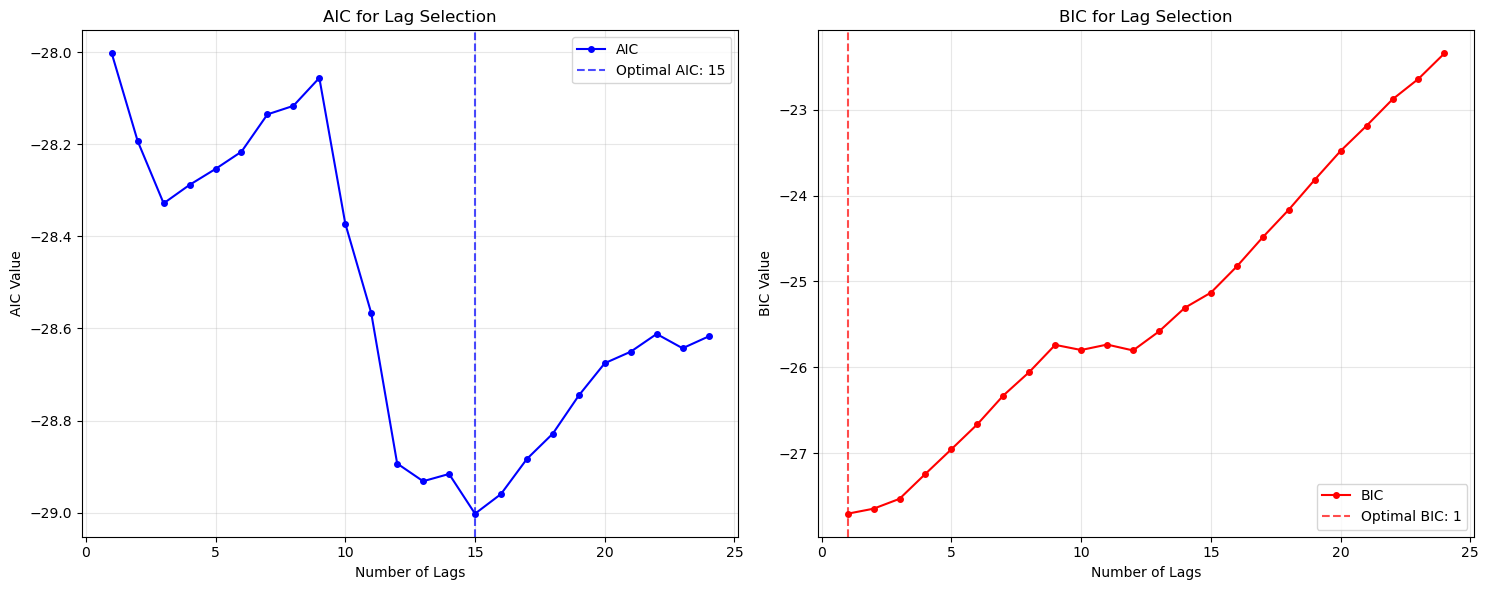

In [14]:
optimal_aic_lag, optimal_bic_lag, lag_results = AIC_BIC(df[["Station CPI","Station DPI","Station Retail","Station Unemployment","Station Sentiment"]].dropna())
# we will chose AIC as we don't have a large data set as we only have 400 points. We also want to favor a predictive feature
plot_lag_selection(lag_results, optimal_aic_lag, optimal_bic_lag)


In [15]:
#With our selected lag from AIC as to be better with BIC seeming to overfit due to its high penalty to complex functions
# Here we are looking at the correlation matrix of our residuals
model = VAR(df[["Station CPI","Station DPI","Station Retail","Station Unemployment","Station Sentiment"]].dropna())
results = model.fit(optimal_aic_lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 07, Dec, 2025
Time:                     15:01:40
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -25.1306
Nobs:                     389.000    HQIC:                  -27.4675
Log likelihood:           3261.15    FPE:                2.60275e-13
AIC:                     -29.0025    Det(Omega_mle):     1.06639e-13
--------------------------------------------------------------------
Results for equation Station CPI
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.000910         0.000778            1.170           0.242
L1.Station CPI                   0.421809         0.060487            6.974           0.000
L1.Station

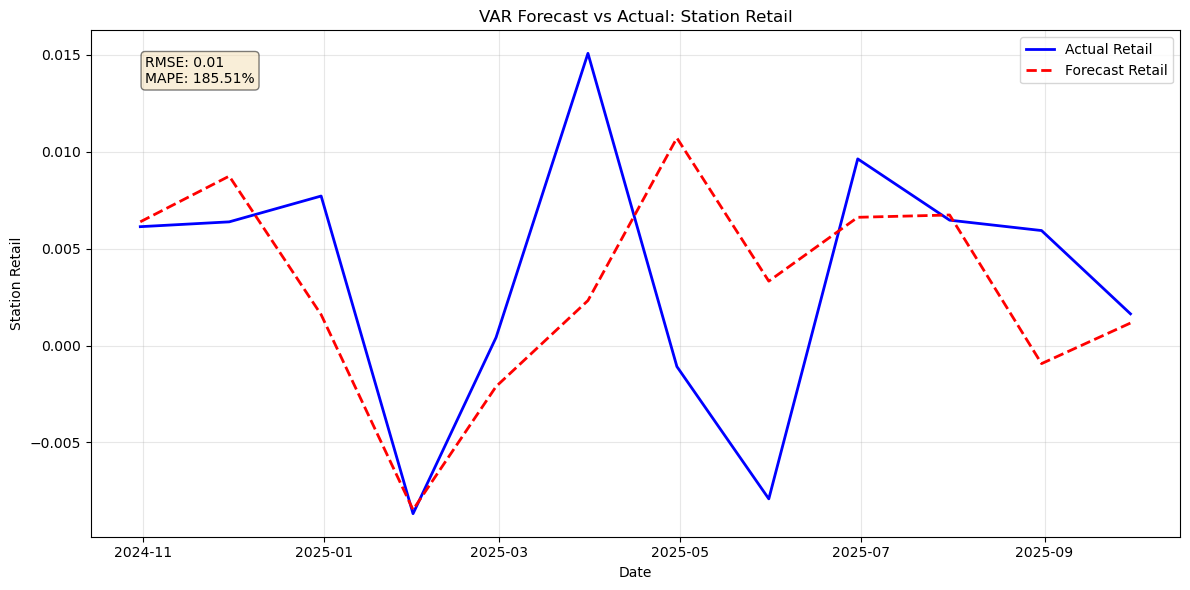

Retail Forecast Metrics:
RMSE: 0.01
MAPE: 185.51%


In [16]:
# Prepare the data
economic_vars = ["Station CPI","Station DPI","Station Retail","Station Unemployment","Station Sentiment"]
endog = df[economic_vars].dropna()
n_obs = 12
train_full, test_full = endog[:-n_obs], endog[-n_obs:]

# Fit VAR model with optimal lag
lag_order = optimal_aic_lag  
model = VAR(train_full)
results = model.fit(lag_order)

# Generate forecast
forecast_input = train_full.values[-lag_order:]
forecast_full = results.forecast(forecast_input, steps=n_obs)

# Create forecast DataFrame
forecast_df = pd.DataFrame(forecast_full, index=test_full.index, columns=economic_vars)

# Extract retail data
retail_actual = test_full['Station Retail']
retail_forecast = forecast_df['Station Retail']

# Plot only retail
plt.figure(figsize=(12,6))
plt.plot(retail_actual.index, retail_actual, label='Actual Retail', linewidth=2, color='blue')
plt.plot(retail_forecast.index, retail_forecast, label='Forecast Retail', linestyle='--', linewidth=2, color='red')
plt.title('VAR Forecast vs Actual: Station Retail')
plt.xlabel('Date')
plt.ylabel('Station Retail')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add forecast error metrics
rmse = np.sqrt(((retail_actual - retail_forecast) ** 2).mean())
mape = (abs((retail_actual - retail_forecast) / retail_actual) * 100).mean()

# Add text box with metrics
textstr = f'RMSE: {rmse:.2f}\nMAPE: {mape:.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.show()

# Print metrics
print(f"Retail Forecast Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# this tests if our residuals are correlated to make sure we are not missing a crucial part of data
residuals = results.resid

# Create a summary table
summary_data = []

for column in residuals.columns:
    variable_residuals = residuals[column]
    lb_results = acorr_ljungbox(variable_residuals, lags=15, return_df=True)
    final_result = lb_results.iloc[-1]
    
    summary_data.append({
        'Variable': column,
        'LB_Statistic': final_result['lb_stat'],
        'P_Value': final_result['lb_pvalue'],
        'Significant': final_result['lb_pvalue'] <= 0.05
    })

# Create a nice summary DataFrame
summary_df = pd.DataFrame(summary_data)
print("\nSummary of Ljung-Box Tests (lags=15):")
print("=" * 55)
print(summary_df.round(4))

# Count results
significant_count = summary_df['Significant'].sum()
total_count = len(summary_df)

print(f"\nDiagnostic Summary:")
print(f"- {total_count - significant_count}/{total_count} variables pass (no autocorrelation)")
print(f"- {significant_count}/{total_count} variables fail (significant autocorrelation)")


Summary of Ljung-Box Tests (lags=15):
               Variable  LB_Statistic  P_Value  Significant
0           Station CPI        3.6959   0.9986        False
1           Station DPI        5.1123   0.9911        False
2        Station Retail        3.8842   0.9981        False
3  Station Unemployment        2.1729   0.9999        False
4     Station Sentiment        4.8597   0.9932        False

Diagnostic Summary:
- 5/5 variables pass (no autocorrelation)
- 0/5 variables fail (significant autocorrelation)


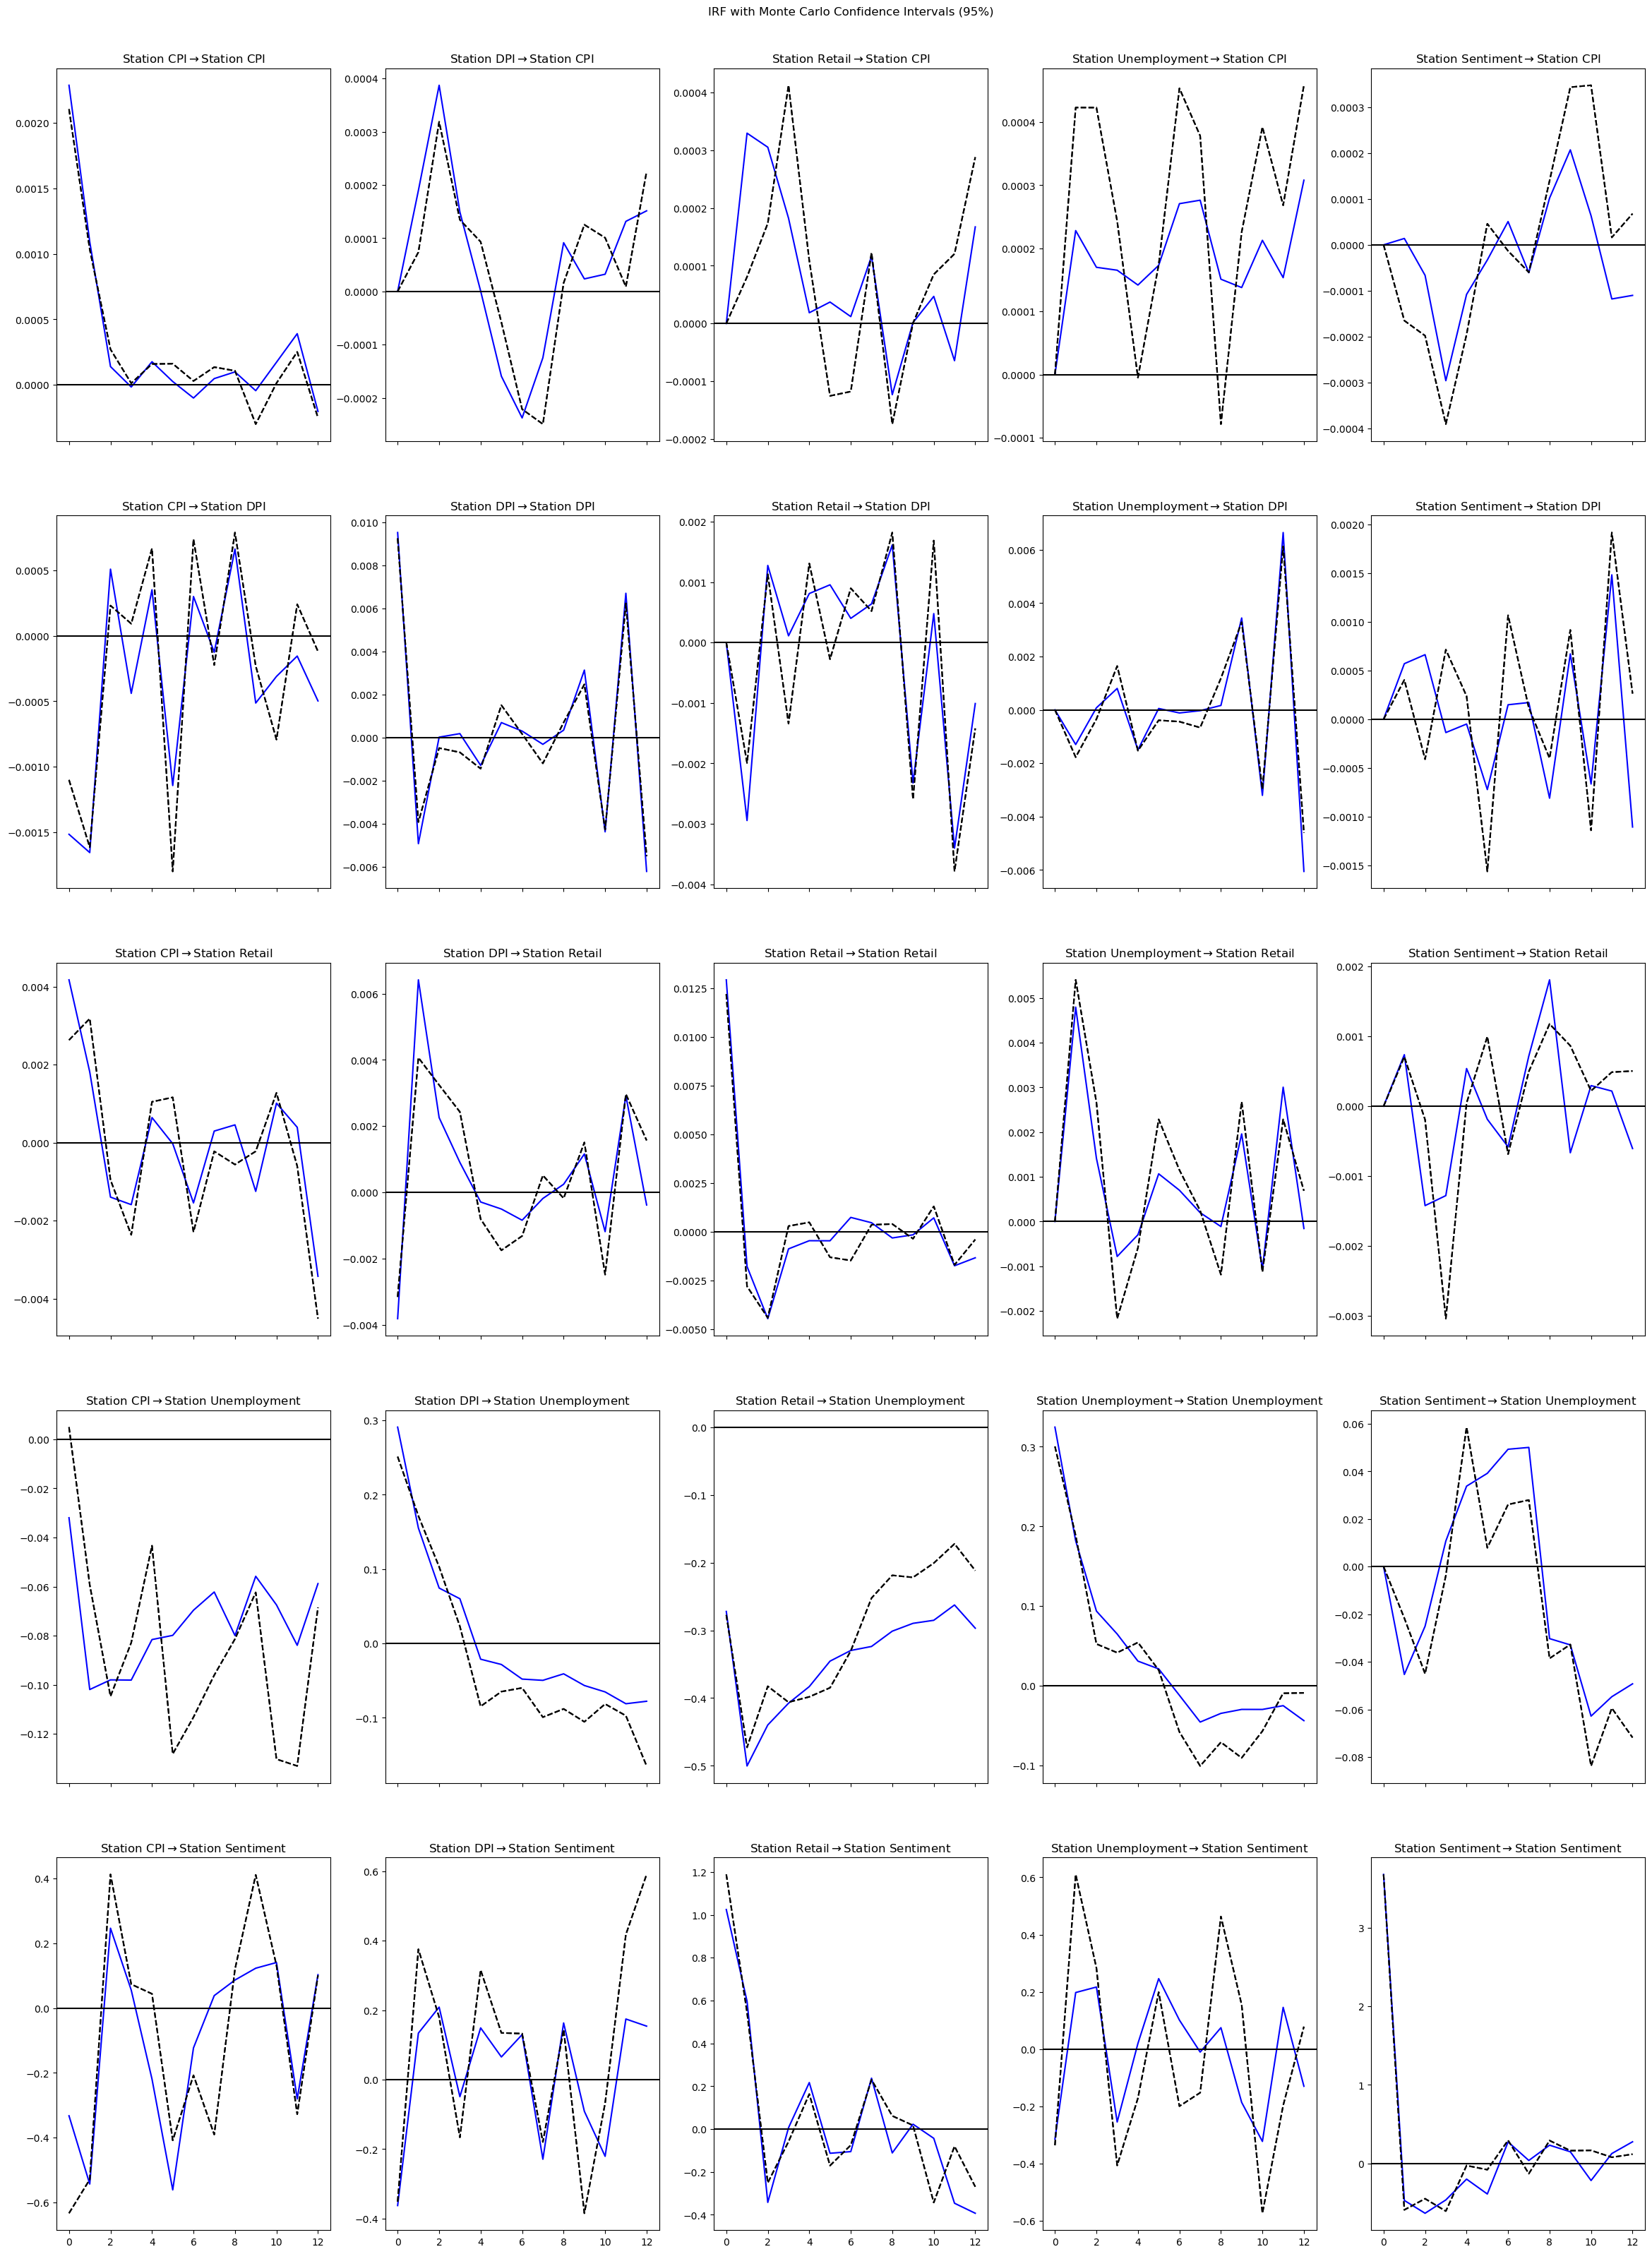

In [18]:
# this is impulse respose function to examine impluse response from shocks. We use monte carlo simulations to simulate the market and to get confidence
#If the blue line is outside the dotted line it shows significance.
irf = results.irf(periods=12)
irf_ci = irf.plot(orth=True, plot_stderr=True, stderr_type='mc', repl=1000, seed=123, 
                  figsize=(25, 35))
plt.suptitle('IRF with Monte Carlo Confidence Intervals (95%)', y=0.95)
plt.show()

Forecast Error Variance Decomposition:
FEVD for Station CPI
      Station CPI  Station DPI  Station Retail  Station Unemployment  Station Sentiment
0        1.000000     0.000000        0.000000              0.000000           0.000000
1        0.970307     0.005433        0.016379              0.007852           0.000029
2        0.931627     0.026888        0.029131              0.011688           0.000667
3        0.909238     0.029379        0.033113              0.015261           0.013010
4        0.905552     0.029119        0.032868              0.017936           0.014524
5        0.898305     0.032405        0.032793              0.021941           0.014557
6        0.882258     0.039460        0.032176              0.031480           0.014626
7        0.869407     0.040953        0.033508              0.041230           0.014902
8        0.863026     0.041703        0.035227              0.043894           0.016150
9        0.855968     0.041423        0.034928              

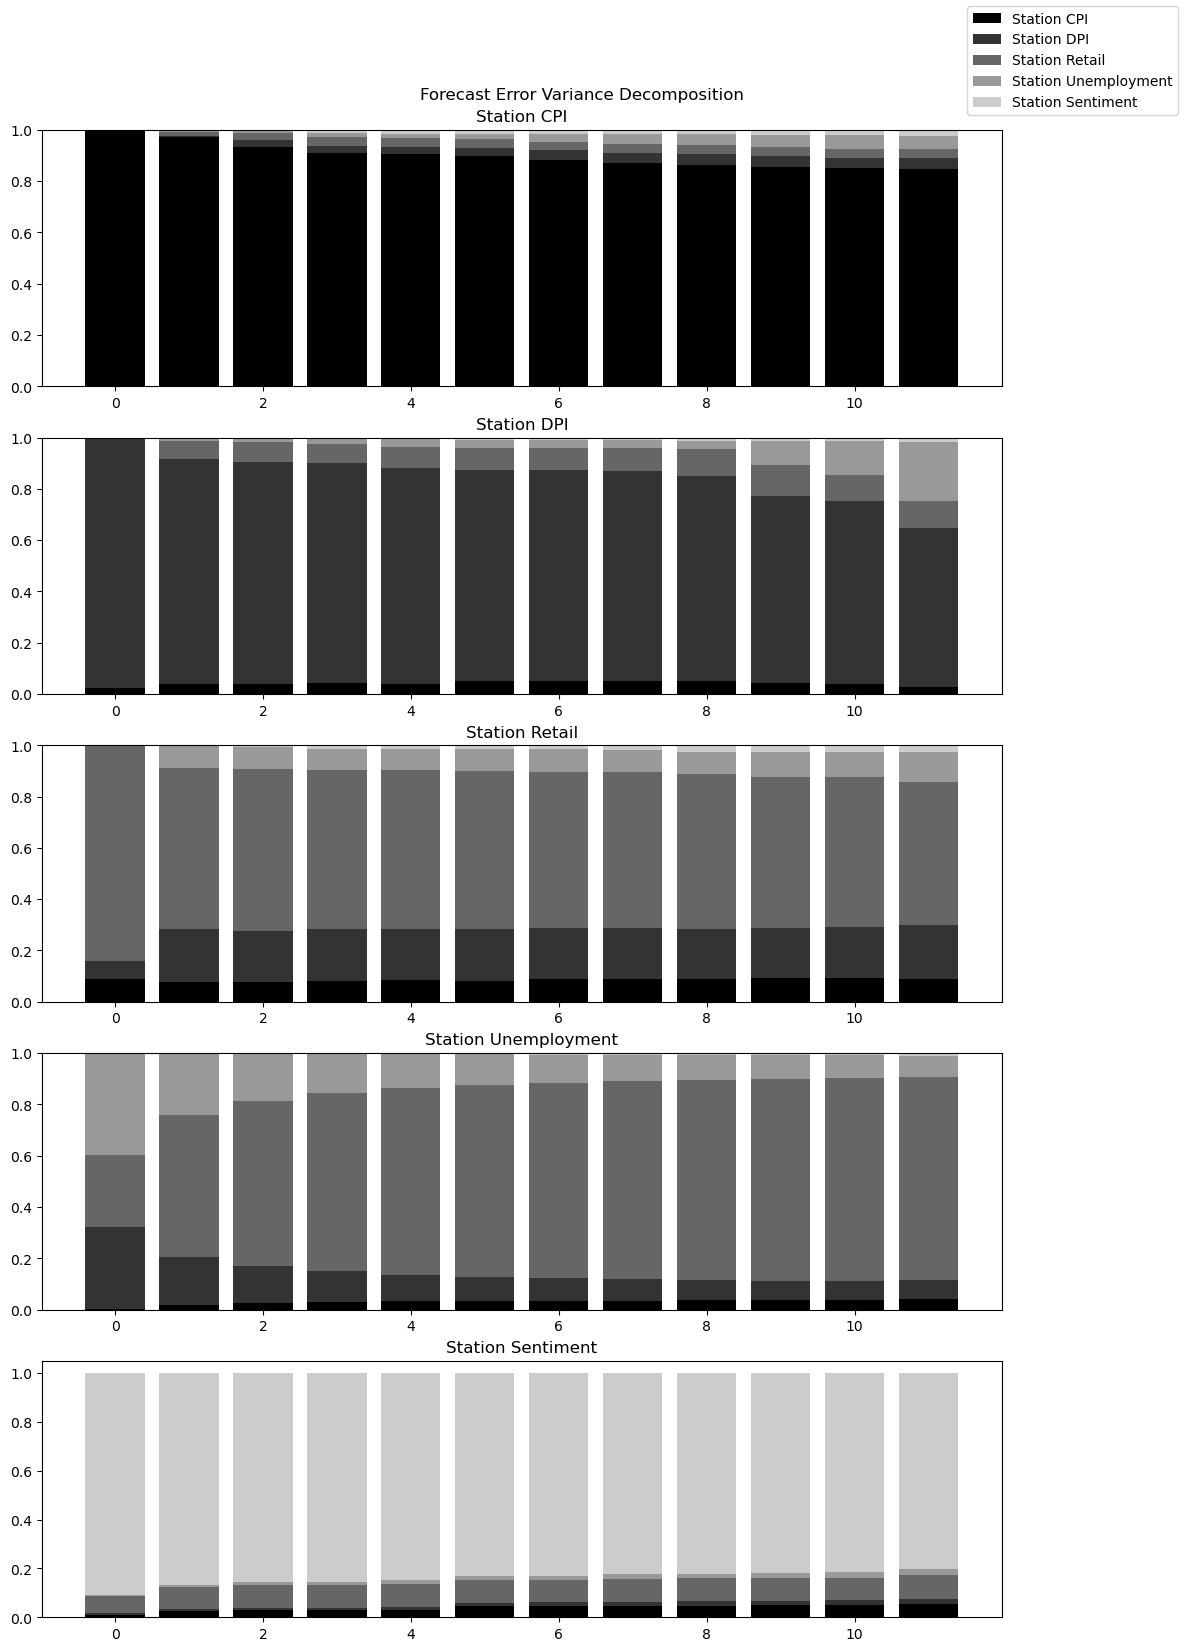

In [19]:
# Perform FEVD, Forecast Error Variance Decomposition this shows how much of the forecast is explained by other variables
fevd = results.fevd(periods=12)

print("Forecast Error Variance Decomposition:")
print("=" * 50)

# Display FEVD results
fevd_summary = fevd.summary()


# Access the FEVD array directly
fevd_array = fevd.decomp
print(f"\nFEVD array shape: {fevd_array.shape}")
# Plot FEVD
fevd_plot = fevd.plot(figsize=(12, 17))
plt.suptitle('Forecast Error Variance Decomposition', y=0.95)
plt.show()

In [20]:
# we want to make causal infrences to see how different varibles have different effects on each other
from statsmodels.tsa.stattools import grangercausalitytests

def var_granger_tests(results):
    variables = results.names
    lag_order = results.k_ar
    test_results = {}

    for cause in variables:
        for effected in variables:
            if cause != effected:
                test = results.test_causality(effected, cause, kind='f')
                p = test.pvalue
                test_results[(cause, effected)] = p

    return test_results

In [21]:
gc = var_granger_tests(results)
sig_gc = {k: v for k, v in gc.items() if v < 0.05}

for (cause, effected), p in sig_gc.items():
    print(f"{cause} → {effected} Granger-causes (p={p:.4f})")


Station CPI → Station Retail Granger-causes (p=0.0196)
Station CPI → Station Sentiment Granger-causes (p=0.0105)
Station DPI → Station CPI Granger-causes (p=0.0066)
Station Retail → Station CPI Granger-causes (p=0.0050)
Station Retail → Station DPI Granger-causes (p=0.0000)
Station Retail → Station Unemployment Granger-causes (p=0.0000)
Station Unemployment → Station DPI Granger-causes (p=0.0000)
Station Unemployment → Station Retail Granger-causes (p=0.0000)
Station Sentiment → Station DPI Granger-causes (p=0.0105)
Station Sentiment → Station Retail Granger-causes (p=0.0337)


Rolling window length = 120 observations
VAR lag_order = 15
Total rolling forecast points = 284
Computing baseline AR(1) and Random Walk rolling forecasts...
Baseline results (rolling-window):
AR(1)  RMSE: 0.0272849, MAE: 0.00978523
RW     RMSE: 0.0273666, MAE: 0.0127898
Trying 15 VAR subsets (rolling-window)...


VAR subsets (rolling):   0%|          | 0/15 [00:00<?, ?it/s]


All subset results (sorted by VAR RMSE):


,Variables,VAR_RMSE,VAR_MAE,AR_RMSE,AR_MAE,RW_RMSE,RW_MAE,Best_by_RMSE
0,"(Station Retail, Station Sentiment)",0.043592,0.017716,0.027285,0.009785,0.027367,0.01279,AR(1)
1,"(Station CPI, Station Retail)",0.052807,0.019520,0.027285,0.009785,0.027367,0.01279,AR(1)
2,"(Station CPI, Station Retail, Station Sentiment)",0.053116,0.021508,0.027285,0.009785,0.027367,0.01279,AR(1)
3,"(Station Retail, Station Unemployment, Station Sentiment)",0.053960,0.020943,0.027285,0.009785,0.027367,0.01279,AR(1)
4,"(Station Retail, Station Unemployment)",0.053981,0.019699,0.027285,0.009785,0.027367,0.01279,AR(1)
5,"(Station DPI, Station Retail, Station Sentiment)",0.054098,0.024635,0.027285,0.009785,0.027367,0.01279,AR(1)
6,"(Station DPI, Station Retail)",0.054407,0.022144,0.027285,0.009785,0.027367,0.01279,AR(1)
7,"(Station CPI, Station Retail, Station Unemployment, Station Sentiment)",0.055295,0.024160,0.027285,0.009785,0.027367,0.01279,AR(1)
8,"(Station CPI, Station DPI, Station Retail)",0.057361,0.025369,0.027285,0.009785,0.027367,0.01279,AR(1)
9,"(Station CPI, Station DPI, Station Retail, Station Sentiment)",0.060277,0.027648,0.027285,0.009785,0.027367,0.01279,AR(1)



Best rolling-window VAR subset: ['Station Retail', 'Station Sentiment'] with RMSE: 0.04359163076526127


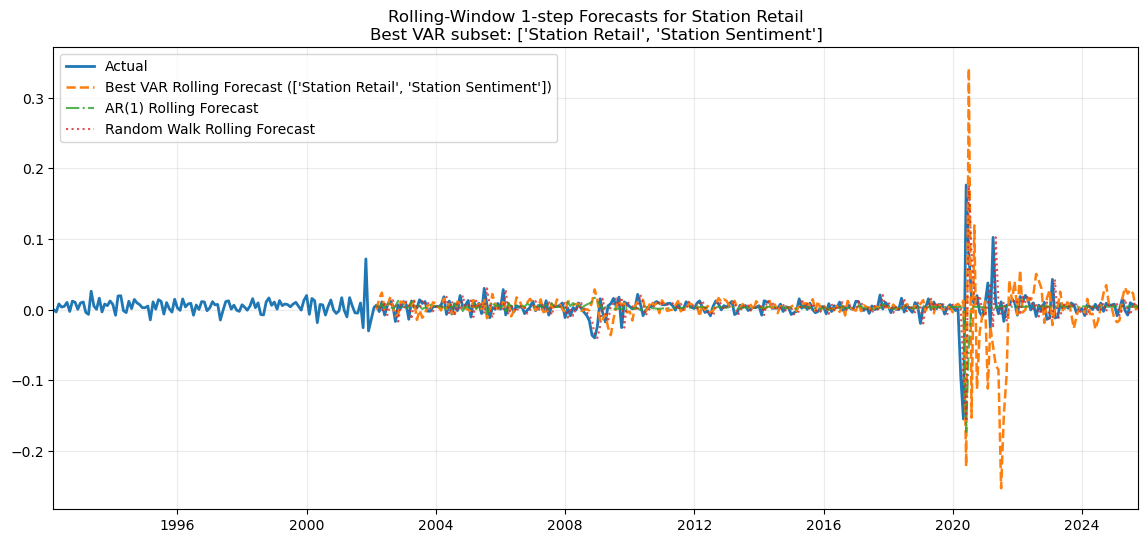

Saved results to rolling_var_subset_comparison_results.csv


In [50]:
# Full rolling-window VAR comparison engine
# Paste directly into your notebook (requires df and optimal_aic_lag)

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Optional progress bar
try:
    from tqdm.auto import tqdm
    use_tqdm = True
except:
    use_tqdm = False

# ---------------------------
# CONFIG
# ---------------------------
all_vars = ["Station CPI","Station DPI","Station Retail","Station Unemployment","Station Sentiment"]
target_var = "Station Retail"

# Use the same logic as your expanding engine:
max_lag_cap = 20
lag_order = int(min(optimal_aic_lag, max_lag_cap))

# Rolling window length (in observations)
# For monthly data: 10 years = 120 months
window_size = 120   # <-- change to 180 if you want 15 years

print(f"Rolling window length = {window_size} observations")
print(f"VAR lag_order = {lag_order}")

# Clean + align full dataset
df_all = df[all_vars].dropna().copy()
dates = df_all.index
n_periods = len(df_all)

# Number of forecasts = number of positions where rolling window is valid
n_forecasts = n_periods - window_size
print(f"Total rolling forecast points = {n_forecasts}")

# ---------------------------
# Baseline models (AR(1) and Random Walk) — rolling window to match VAR testing
# ---------------------------
def rolling_baselines(series, window_size):
    """Returns AR(1) and RW forecasts using rolling window."""
    s = series.loc[df_all.index]
    ar_preds = []
    rw_preds = []

    for end in range(window_size, len(s)):
        train = s.iloc[end-window_size:end]

        # AR(1)
        try:
            model = AutoReg(train, lags=1, old_names=False).fit()
            pred_ar = model.predict(start=len(train), end=len(train)).iloc[0]
        except:
            pred_ar = np.nan

        # Random Walk
        pred_rw = train.iloc[-1]

        ar_preds.append(pred_ar)
        rw_preds.append(pred_rw)

    idx = s.index[window_size:]
    return pd.Series(ar_preds, index=idx), pd.Series(rw_preds, index=idx)

print("Computing baseline AR(1) and Random Walk rolling forecasts...")
ar_series, rw_series = rolling_baselines(df_all[target_var], window_size)

# Actuals aligned with rolling forecasts
actuals_series = df_all[target_var].iloc[window_size:]

def calc_metrics(true, pred):
    mask = ~np.isnan(pred.values)
    if mask.sum() == 0:
        return np.inf, np.inf
    rmse = np.sqrt(mean_squared_error(true.values[mask], pred.values[mask]))
    mae = mean_absolute_error(true.values[mask], pred.values[mask])
    return rmse, mae

baseline_ar_rmse, baseline_ar_mae = calc_metrics(actuals_series, ar_series)
baseline_rw_rmse, baseline_rw_mae = calc_metrics(actuals_series, rw_series)

print("Baseline results (rolling-window):")
print(f"AR(1)  RMSE: {baseline_ar_rmse:.6g}, MAE: {baseline_ar_mae:.6g}")
print(f"RW     RMSE: {baseline_rw_rmse:.6g}, MAE: {baseline_rw_mae:.6g}")

# ---------------------------
# Iterate all VAR subsets (must include target_var)
# ---------------------------
subsets = []
for k in range(2, len(all_vars)+1):
    for combo in itertools.combinations(all_vars, k):
        if target_var in combo:
            subsets.append(list(combo))

print(f"Trying {len(subsets)} VAR subsets (rolling-window)...")

results_rows = []
best_var_rmse = np.inf
best_var_predictions = None
best_var_subset = None

iterable = subsets
if use_tqdm:
    iterable = tqdm(subsets, desc="VAR subsets (rolling)")

# ---------------------------
# Main rolling-window VAR loop
# ---------------------------
for subset in iterable:
    df_sub = df_all[subset]
    preds = []

    for end in range(window_size, len(df_sub)):
        train = df_sub.iloc[end-window_size:end]

        # Not enough observations
        if len(train) <= lag_order:
            preds.append(np.nan)
            continue

        try:
            model = VAR(train)
            res = model.fit(lag_order)

            fc = res.forecast(train.values[-lag_order:], steps=1)[0]
            pred_target = fc[list(train.columns).index(target_var)]
        except:
            pred_target = np.nan

        preds.append(pred_target)

    preds_series = pd.Series(preds, index=df_sub.index[window_size:])

    rmse, mae = calc_metrics(actuals_series, preds_series)

    # Determine which model wins by RMSE
    winner = min(
        [("VAR", rmse), ("AR(1)", baseline_ar_rmse), ("RandomWalk", baseline_rw_rmse)],
        key=lambda x: x[1]
    )[0]

    results_rows.append({
        "Variables": tuple(subset),
        "VAR_RMSE": rmse,
        "VAR_MAE": mae,
        "AR_RMSE": baseline_ar_rmse,
        "AR_MAE": baseline_ar_mae,
        "RW_RMSE": baseline_rw_rmse,
        "RW_MAE": baseline_rw_mae,
        "Best_by_RMSE": winner
    })

    # Track best VAR
    if rmse < best_var_rmse:
        best_var_rmse = rmse
        best_var_predictions = preds_series
        best_var_subset = subset

# ---------------------------
# Produce summary table
# ---------------------------
results_df = pd.DataFrame(results_rows)
results_df = results_df.sort_values("VAR_RMSE").reset_index(drop=True)

pd.set_option('display.max_colwidth', 200)
print("\nAll subset results (sorted by VAR RMSE):")
display(results_df)

def pick_winner_row(row):
    rmse_vals = {"VAR": row["VAR_RMSE"], "AR(1)": row["AR_RMSE"], "RandomWalk": row["RW_RMSE"]}
    return min(rmse_vals, key=rmse_vals.get)

results_df["Winner"] = results_df.apply(pick_winner_row, axis=1)

print("\nBest rolling-window VAR subset:", best_var_subset, "with RMSE:", best_var_rmse)

# ---------------------------
# Plot best VAR vs baselines
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(df_all[target_var], label="Actual", linewidth=2)
plt.plot(best_var_predictions.index, best_var_predictions.values,
         label=f"Best VAR Rolling Forecast ({best_var_subset})", linestyle="--", linewidth=1.8)

plt.plot(ar_series.index, ar_series.values, label="AR(1) Rolling Forecast", linestyle="-.", alpha=0.8)
plt.plot(rw_series.index, rw_series.values, label="Random Walk Rolling Forecast", linestyle=":", alpha=0.8)

plt.title(f"Rolling-Window 1-step Forecasts for {target_var}\nBest VAR subset: {best_var_subset}")
plt.legend(loc='upper left')
plt.grid(alpha=0.25)
plt.xlim(df_all.index[0], df_all.index[-1])
plt.show()

# ---------------------------
# Save results
# ---------------------------
results_df.to_csv("rolling_var_subset_comparison_results.csv", index=False)
print("Saved results to rolling_var_subset_comparison_results.csv")
